In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline


In [63]:
df = pd.read_csv(r"F:\My Documents\Lending Club Data\lending-club-loan-data\loan.csv",
                low_memory = False)

#original_df = df.copy()

df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(df.shape)
df.info()

(2260668, 145)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [4]:
df.isnull().sum().sort_values(ascending = False)

id                                            2260668
member_id                                     2260668
url                                           2260668
orig_projected_additional_accrued_interest    2252242
hardship_start_date                           2250055
hardship_end_date                             2250055
payment_plan_start_date                       2250055
hardship_length                               2250055
hardship_dpd                                  2250055
hardship_loan_status                          2250055
hardship_payoff_balance_amount                2250055
deferral_term                                 2250055
hardship_last_payment_amount                  2250055
hardship_status                               2250055
hardship_reason                               2250055
hardship_type                                 2250055
hardship_amount                               2250055
settlement_percentage                         2227612
settlement_term             

There are multiple columns where every value is null so those columns will be removed. There seem to be about 100,000 rows that have values related to hardship and the rest of the loans have nothing in regards to hardships which makes sense. I will keep the original dataframe but I will remove multiple columns from my working dataframe.

Luckily there is an excel document that came with this data that explains the columns and terms being used. 

orig_projected_additional_accrued_interest has the description: The original projected additional interest amount that will accrue for the given hardship payment plan as of the Hardship Start Date. This field will be null if the borrower has broken their hardship payment plan.

In [5]:
df = df.drop(['id', 'member_id', 'url'], axis = 1)


In [6]:
df.shape

(2260668, 142)

Text(0.5, 1.0, 'Amount applied for by borrower')

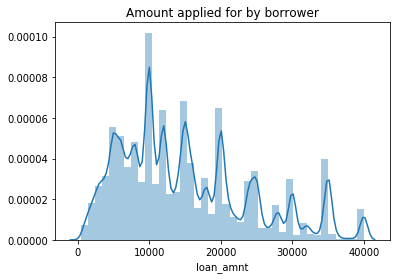

In [66]:
sns.distplot(df['loan_amnt'], bins = 40).set_title('Amount applied for by borrower')
#Can turn into histogram to make a count instead of percentage

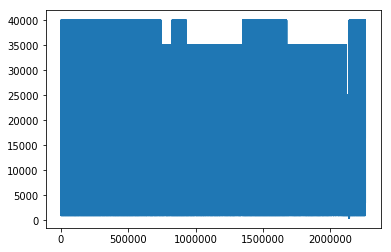

In [69]:
sns.lineplot(data = df['loan_amnt'], palette = 'bright')

In [8]:
df['issue_d'].head()

0    Dec-2018
1    Dec-2018
2    Dec-2018
3    Dec-2018
4    Dec-2018
Name: issue_d, dtype: object

In [9]:
df['issue_year'] = pd.to_datetime(df['issue_d']).dt.year

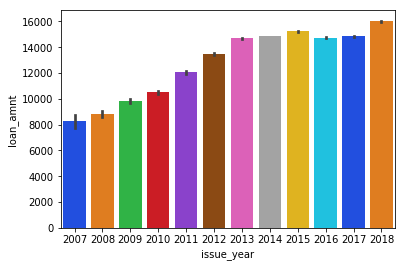

In [10]:
sns.barplot('issue_year', 'loan_amnt', data = df, palette = 'bright')

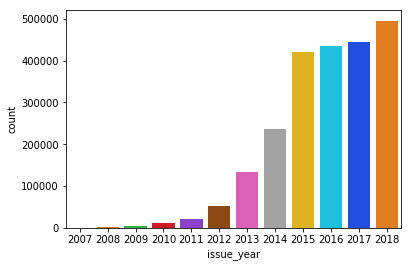

In [11]:
sns.countplot('issue_year', data = df, palette = 'bright')
#How do I plot number of issues loans per year into this bar plot?
#Found out how to do it, countplot. Found how by typing "sns barplot occurrences per year"
#into Google and seeing the documentation for countplot.

Wow that is some really impressive growth.  Assuming of course that this dataset is representative of all of Lending Club's loans. I will do a count of how many occurances of each year there are. 

In [12]:
#df['issue_year'].unique().value_counts
#The above code did not work, I am going to try Counter now

In [13]:
Counter(df['issue_year'])
#It works

Counter({2018: 495242,
         2016: 434407,
         2015: 421095,
         2017: 443579,
         2013: 134814,
         2012: 53367,
         2014: 235629,
         2011: 21721,
         2010: 12537,
         2009: 5281,
         2008: 2393,
         2007: 603})

In [14]:
df['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [15]:
df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

There are multiple categories that reasonably count as bad loans.  Charged Off a loan taken off the books due to no reasonable expectation of payment. https://help.lendingclub.com/hc/en-us/articles/216127747-What-is-the-difference-between-a-loan-that-is-in-default-and-a-loan-that-has-been-charged-off-

The categories I will consider bad are Charged Off, Late(both 16-30 days and 31-120 days), default and "Does not meet the credit policy. Status:Charged Off"(I still don't know what credit policy the loan does not meet but I know enough to know any loan in this category is bad).

In [16]:
bad_statuses = ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)',
               'Does not meet the credit policy. Status:Charged Off', 'Default']

df['good_loan'] = np.nan

def loan_classifier(status):
    if status in bad_statuses:
        return 0
    else:
        return 1
    
df['good_loan'] = df['loan_status'].apply(loan_classifier)

df['good_loan'].head()

0    1
1    1
2    1
3    1
4    1
Name: good_loan, dtype: int64

## Mentor Idea
Maybe I should target the bad loans as my target variable.  This was suggested by Noyuki. Google more on oversampling to understand the issues that are created from imbalanced data. 

In [17]:
Counter(df['good_loan'])

Counter({1: 1972587, 0: 288081})

In [18]:
print(Counter(df['good_loan'])[0]/Counter(df['good_loan'])[1])
print("The current percentage of bad loans is {}%".format((Counter(df['good_loan'])[0]/Counter(df['good_loan'])[1]) * 100))

0.14604222779527595
The current percentage of bad loans is 14.604222779527595%


I do not know if this makes Lending Club loans better or worse then the competition because I have no idea what results the competition is getting but at least I have a number to work with.  

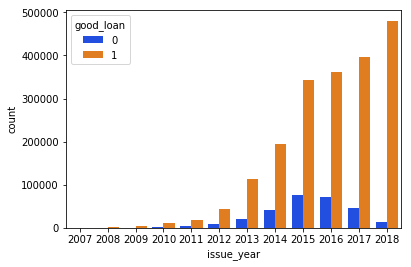

In [19]:
sns.countplot('issue_year',hue = 'good_loan', data = df, palette = 'bright',)

#How would I relabel the 0's to be bad and the 1's to be good?

INvestigate, if possible, whether the loans are becoming better over time or if it usually takes a few years for a loan to turn bad.  I don't know currently. 

Next is feature selection

In [20]:
corr = df.corr().loc[:, 'good_loan'].sort_values()
#Select the top 10 features then see what a regression does
#use iloc to find the column that has good loans 
# df.corr.loc[:, 'good_loan'].sort_values()
#feature_list = corr[-20:]
print(corr)

recoveries                                   -0.490569
collection_recovery_fee                      -0.465110
hardship_dpd                                 -0.232085
int_rate                                     -0.206668
total_rec_late_fee                           -0.131513
sec_app_inq_last_6mths                       -0.097421
acc_open_past_24mths                         -0.094552
inq_last_6mths                               -0.086853
num_tl_op_past_12m                           -0.084050
hardship_amount                              -0.083270
open_rv_24m                                  -0.079876
percent_bc_gt_75                             -0.074229
inq_last_12m                                 -0.074013
bc_util                                      -0.071613
orig_projected_additional_accrued_interest   -0.070585
all_util                                     -0.069046
open_acc_6m                                  -0.067543
open_rv_12m                                  -0.065152
revol_util

After this select the top 20-50 columns(and bottom ones that have a negative correlation) and do a logistic regression.  After this use Naive Bayes, random forest, gradient boost 



When constructing the training data make sure to have a 50/50 sample of good and bad loans when constructing the training set.  For the testing set be sure to keep the original ratio of about 14% bad loans. 

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

This was recommended by Noyuki.

When constructing this model reduce type 2 error as much as possible, this one is priority.  

After the basic regression model try classification report, random forest, gradient boost, xgboost to make more accurate models. 

Look up more on random forest and grid search, also what recall means in this context and with random forests. 

Random forests also make it easier to see feature importance to rank the features. 

After this make the next steps and what questions we could answer with more information. 

Also try embedding images to make things look a bit better. 

Might make a powerpoint to present to the audience, or to make a powerpoint for a general audience and Jupyter Notebook for a more technical presentation. 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [22]:
df.columns[df.columns.str.isnumeric()]
df = df.select_dtypes(exclude = ['object'])  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 108 entries, loan_amnt to good_loan
dtypes: float64(102), int64(6)
memory usage: 1.8 GB


In [23]:
na_array = df.isna().sum().sort_values(ascending = False)

In [24]:
na_list = na_array.index

df = df.drop(na_list[:42], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 66 columns):
loan_amnt                     int64
funded_amnt                   int64
funded_amnt_inv               float64
int_rate                      float64
installment                   float64
annual_inc                    float64
dti                           float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     int64
revol_util                    float64
total_acc                     float64
out_prncp                     float64
out_prncp_inv                 float64
total_pymnt                   float64
total_pymnt_inv               float64
total_rec_prncp               float64
total_rec_int                 float64
total_rec_late_fee            float64
recoveries                    float64
collection_recovery_fee       float64
last_pymnt_amnt    

Some of the variables are very simliar in function and correlation so I should remove some of them, example: total_pymnt and total_pymnt_inv

In [25]:
df.isna().sum().sort_values(ascending = False)

num_tl_120dpd_2m              153657
mo_sin_old_il_acct            139071
bc_util                        76071
percent_bc_gt_75               75379
bc_open_to_buy                 74935
mths_since_recent_bc           73412
pct_tl_nvr_dlq                 70431
avg_cur_bal                    70346
mo_sin_old_rev_tl_op           70277
mo_sin_rcnt_rev_tl_op          70277
num_rev_accts                  70277
total_rev_hi_lim               70276
num_bc_tl                      70276
tot_cur_bal                    70276
tot_coll_amt                   70276
num_accts_ever_120_pd          70276
num_actv_bc_tl                 70276
num_actv_rev_tl                70276
mo_sin_rcnt_tl                 70276
num_il_tl                      70276
tot_hi_cred_lim                70276
num_op_rev_tl                  70276
num_rev_tl_bal_gt_0            70276
num_tl_30dpd                   70276
total_il_high_credit_limit     70276
num_tl_90g_dpd_24m             70276
num_tl_op_past_12m             70276
n

In [26]:
df = df.dropna()
df.info()
#df.to_csv(r"F:\My Documents\Lending Club Data\lending-club-loan-data\smaller_loan.csv")
#The above line only needed to be run once and the file is already made. I am keeping the code
#as a record of what I did. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2013799 entries, 0 to 2260666
Data columns (total 66 columns):
loan_amnt                     int64
funded_amnt                   int64
funded_amnt_inv               float64
int_rate                      float64
installment                   float64
annual_inc                    float64
dti                           float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     int64
revol_util                    float64
total_acc                     float64
out_prncp                     float64
out_prncp_inv                 float64
total_pymnt                   float64
total_pymnt_inv               float64
total_rec_prncp               float64
total_rec_int                 float64
total_rec_late_fee            float64
recoveries                    float64
collection_recovery_fee       float64
last_pymnt_amnt    

In [27]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 42)

F:\Anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [28]:
X = df.drop(['good_loan'], axis = 1)
y = df['good_loan']

X_resampled, y_resampled = rus.fit_resample(X,y)
print(X_resampled.shape)
print(y_resampled.shape)

(500796, 65)
(500796,)


In [29]:
import pprint
pprint.pprint(locals())

{'Counter': <class 'collections.Counter'>,
 'In': ['',
        'import tensorflow as tf\n'
        'import pandas as pd\n'
        'import seaborn as sns\n'
        'import numpy as np\n'
        'import matplotlib.pyplot as plt\n'
        'from collections import Counter\n'
        '\n'
        "get_ipython().run_line_magic('matplotlib', 'inline')",
        'df = pd.read_csv(r"F:\\My Documents\\Lending Club '
        'Data\\lending-club-loan-data\\loan.csv",\n'
        '                low_memory = False)\n'
        '\n'
        '#original_df = df.copy()\n'
        '\n'
        'df.head()',
        'print(df.shape)\ndf.info()',
        'df.isnull().sum().sort_values(ascending = False)',
        "df = df.drop(['id', 'member_id', 'url'], axis = 1)",
        'df.shape',
        "sns.barplot(df['loan_amnt']).set_title('Amount applied for by "
        "borrower')\n"
        '#Can turn into histogram to make a count instead of percentage',
        "df['issue_d'].head()",
        "df['issue_

 'X':          loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
0             2500         2500           2500.0     13.56        84.92   
1            30000        30000          30000.0     18.94       777.23   
2             5000         5000           5000.0     17.97       180.69   
3             4000         4000           4000.0     18.94       146.51   
4            30000        30000          30000.0     16.14       731.78   
5             5550         5550           5550.0     15.02       192.45   
7             6000         6000           6000.0     13.56       203.79   
8             5000         5000           5000.0     17.97       180.69   
9             6000         6000           6000.0     14.47       206.44   
10            5500         5500           5500.0     22.35       211.05   
11           28000        28000          28000.0     11.31       613.13   
12           11200        11200          11200.0      8.19       351.95   
13            6500 

 'df':          loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
0             2500         2500           2500.0     13.56        84.92   
1            30000        30000          30000.0     18.94       777.23   
2             5000         5000           5000.0     17.97       180.69   
3             4000         4000           4000.0     18.94       146.51   
4            30000        30000          30000.0     16.14       731.78   
5             5550         5550           5550.0     15.02       192.45   
7             6000         6000           6000.0     13.56       203.79   
8             5000         5000           5000.0     17.97       180.69   
9             6000         6000           6000.0     14.47       206.44   
10            5500         5500           5500.0     22.35       211.05   
11           28000        28000          28000.0     11.31       613.13   
12           11200        11200          11200.0      8.19       351.95   
13            6500

In [30]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

                            df:   1.0GiB
                             X: 1014.0MiB
                   X_resampled: 248.4MiB
                             y:  30.7MiB
                   y_resampled:   3.8MiB
                            _4:  16.4KiB
                            _2:  13.7KiB
                          corr:   8.6KiB
                      na_array:   8.6KiB
                       na_list:   7.7KiB


In [31]:
del df
del X


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = .2 )
rfc = RandomForestClassifier(n_estimators = 100)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [33]:
y_pred = rfc.predict(X_test)

In [34]:
from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9605531150159744


## Random Forest Result
Accuracy 95% so that's good, need to explore this further 

In [35]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print(conf_matrix[1][1])
print(conf_matrix.sum())
print(conf_matrix[1].sum())

[[46397  3531]
 [  420 49812]]
49812
100160
50232


In [36]:
print("Misclassification Rate: " + 
      str(((conf_matrix[0][1] + conf_matrix[1][0]) / conf_matrix.sum())*100 ) +'%')
print("True positive rate: " + 
      str((conf_matrix[1][1] / (conf_matrix[1].sum()))*100 ) +'%')
print("False positive rate: " +
     str((conf_matrix[0][1] / (conf_matrix[0].sum()))*100 ) +'%')
print("True negative rate: "+
     str((conf_matrix[0][0] / (conf_matrix[0].sum()))*100 ) +'%')

Misclassification Rate: 3.944688498402556%
True positive rate: 99.1638795986622%
False positive rate: 7.072183944880628%
True negative rate: 92.92781605511937%


# Confusion Matrix Results
Looks good overall, 95% accuracy. But the 7.1% false positive rate could hopefully be improved by increasing punishments for false positives. 


### Confusion Matrix:
 [46645  3600] <br>
 [  427 49488]


In [37]:
print(Counter(y_pred))
#Sanity check that the predicted yes and actual yes are both the good loans


Counter({1: 53343, 0: 46817})


# Mentor Question

So I have this model that is accurate but how can I use that model to make predictions for all of the rows in the original dataframe?  Will I have to remove every column that has a null value?  I have no idea 

In [38]:
#df.loc[~df['sec_app_revol_util'].isnull(), 'good_loan'].mean()
#example_list = ['sec_app_revol_util']

In [41]:
#Finding if the target variable is significantly different for when certain
#columns are null or not. 

'''
for feature in example_list:
    print(feature)
    print(df.loc[df[feature].isnull(), 'good_loan'].mean())
    print(df.loc[~df[feature].isnull(), 'good_loan'].mean())
    print() '''
#Something I used to try and find significance in different columns

"\nfor feature in example_list:\n    print(feature)\n    print(df.loc[df[feature].isnull(), 'good_loan'].mean())\n    print(df.loc[~df[feature].isnull(), 'good_loan'].mean())\n    print() "

Make a list of different columns to place into the above for loop and then put that in, not all columns. 

I can take the two above loc statements and place them both into a t test to see if the difference is significant 

In [46]:
y_resampled.shape

(500796,)

Cool, I was able to get another random forest model with similiar results, only slightly better. 

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc

In [48]:
learning_rates = [.05, .1, .25, .5, .75, 1]

for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators = 20, learning_rate = learning_rate, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb.score(X_test, y_test)))
    print()
#Best score on the test set is with learning rate .75

Learning rate:  0.05
Accuracy score (training): 0.903
Accuracy score (test): 0.905

Learning rate:  0.1
Accuracy score (training): 0.907
Accuracy score (test): 0.908

Learning rate:  0.25
Accuracy score (training): 0.947
Accuracy score (test): 0.947

Learning rate:  0.5
Accuracy score (training): 0.954
Accuracy score (test): 0.954

Learning rate:  0.75
Accuracy score (training): 0.955
Accuracy score (test): 0.955

Learning rate:  1
Accuracy score (training): 0.955
Accuracy score (test): 0.956



In [49]:
gb = GradientBoostingClassifier(n_estimators = 20, learning_rate = .75, random_state = 0)
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.75, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [52]:
from sklearn.metrics import accuracy_score
gb_predictions = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Accuracy: " + str(gb_accuracy * 100) + "%")

Accuracy: 95.4932108626198%


In [53]:
gb_conf_matrix = confusion_matrix(y_test, gb_predictions)
print("Misclassification Rate: " + 
      str(((gb_conf_matrix[0][1] + gb_conf_matrix[1][0]) / gb_conf_matrix.sum())*100 ) +'%')
print("True positive rate: " + 
      str((gb_conf_matrix[1][1] / (gb_conf_matrix[1].sum()))*100 ) +'%')
print("False positive rate: " +
     str((gb_conf_matrix[0][1] / (gb_conf_matrix[0].sum()))*100 ) +'%')
print("True negative rate: "+
     str((gb_conf_matrix[0][0] / (gb_conf_matrix[0].sum()))*100 ) +'%')

Misclassification Rate: 4.506789137380192%
True positive rate: 98.8792005096353%
False positive rate: 7.913395289216471%
True negative rate: 92.08660471078353%


Random forest still looks the best but only barely. 

In [54]:
from xgboost import XGBClassifier

In [55]:
XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [56]:
from sklearn.metrics import accuracy_score

In [57]:
XGB_y_pred = XGB_model.predict(X_test)
predictions = [round(value) for value in XGB_y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy * 100) + "%")

Accuracy: 95.3973642172524%


In [58]:
XGB_conf_matrix = confusion_matrix(y_test, XGB_y_pred)
print("Misclassification Rate: " + 
      str(((XGB_conf_matrix[0][1] + XGB_conf_matrix[1][0]) / XGB_conf_matrix.sum())*100 ) +'%')
print("True positive rate: " + 
      str((XGB_conf_matrix[1][1] / (XGB_conf_matrix[1].sum()))*100 ) +'%')
print("False positive rate: " +
     str((XGB_conf_matrix[0][1] / (XGB_conf_matrix[0].sum()))*100 ) +'%')
print("True negative rate: "+
     str((XGB_conf_matrix[0][0] / (XGB_conf_matrix[0].sum()))*100 ) +'%')

Misclassification Rate: 4.602635782747604%
True positive rate: 98.98272017837235%
False positive rate: 8.209822143887198%
True negative rate: 91.79017785611279%


Slightly worse then the random forest model. 

In [59]:
from sklearn.naive_bayes import GaussianNB

gaussian_model = GaussianNB()

gaussian_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [60]:
gaussian_y_pred = gaussian_model.predict(X_test)
gaussian_accuracy = accuracy_score(y_test, gaussian_y_pred)
print("Accuracy: " + str(gaussian_accuracy * 100) + "%")

Accuracy: 80.21265974440894%


The Gaussian model does not work well. Perhaps it could be optimized but I am getting far better results far faster with other models.  Random forest is still in the lead. 